In [1]:
import os.path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import cv2.aruco as aruco
import glob

## Measure the distance from an image

In [2]:
def load_coefficients(path):
    """ Loads camera matrix and distortion coefficients. """
    # FILE_STORAGE_READ
    cv_file = cv2.FileStorage(path, cv2.FILE_STORAGE_READ)

    # note we also have to specify the type to retrieve other wise we only get a
    # FileNode object back instead of a matrix
    camera_matrix = cv_file.getNode("K").mat()
    dist_matrix = cv_file.getNode("D").mat()

    cv_file.release()
    return [camera_matrix, dist_matrix]

def cv2_imshow(image):
    plt.figure(dpi=200)
    mode = len(np.shape(image))
    if mode==3:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    elif mode==2:
        plt.imshow(image, cmap='gray')
    else:
        print('Unsuported image size')
        raise
    plt.xticks([]), plt.yticks([])
    plt.axis('off')

In [3]:
[camera_matrix, dist_matrix] = load_coefficients('13pro_coef_img')

In [4]:
img = cv2.imread('50.jpg')

In [5]:
h1, w1 = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_matrix, (h1, w1), 0, (h1, w1))
dst1 = cv2.undistort(img, camera_matrix, dist_matrix, None, newcameramtx)
# x, y, w1, h1 = roi
# dst1 = dst1[y:y + h1, x:x + w1]
img=dst1

In [6]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
aruco_dict = aruco.Dictionary_get(aruco.DICT_5X5_250)
parameters =  aruco.DetectorParameters_create()


corners, ids, rejectedImgPoints = aruco.detectMarkers(gray,aruco_dict,parameters=parameters)

In [7]:
if ids is not None:
    #Get rotation matrix rvec；and the  tvec：
    rvec, tvec, _ = aruco.estimatePoseSingleMarkers(corners, 0.05, camera_matrix, dist_matrix)
    # 估计每个标记的姿态并返回值rvet和tvec ---不同
    #rvec为旋转矩阵，tvec为位移矩阵
    # from camera coeficcients
    (rvec-tvec).any() # get rid of that nasty numpy value array error
    #print(rvec)



    #在画面上 标注auruco标签的各轴
    for i in range(rvec.shape[0]):
        # aruco.drawAxis(img, camera_matrix, dist_matrix, rvec[i, :, :], tvec[i, :, :], 0.03)
        result_img = cv2.drawFrameAxes(img, camera_matrix, dist_matrix, rvec[i, :, :], tvec[i, :, :],0.03)
        aruco.drawDetectedMarkers(img, corners,ids)


    ###### 显示id标记 #####
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, "Id: " + str(ids), (0,200), font, 5, (0,0,255),10,cv2.LINE_AA)
    distance = ((tvec[0][0][2] + 0.02) * 0.0254) * 100 / 2  # 单位是米
    cv2.putText(img, 'distance:' + str(round(distance, 4)) + str('m'), (0, 400), font, 5, (0, 0, 255), 10,
                    cv2.LINE_AA)

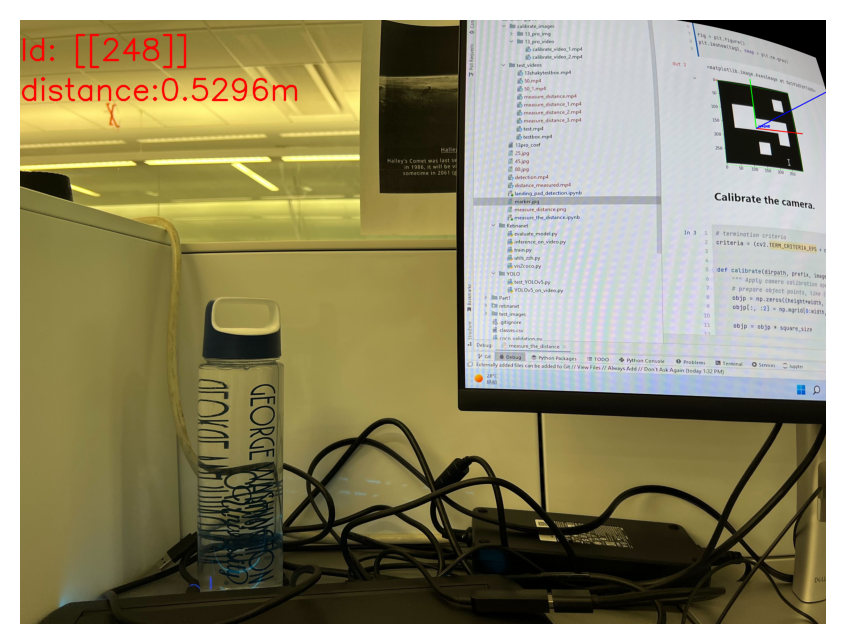

In [8]:
cv2.imwrite('measure_distance.png', img)
cv2_imshow(img)

## Measure the distance from a video

In [9]:
def calibrate(dirpath, video_format, square_size, width=11, height=12):
    # Calibrate the camera from the videos

    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # Load the videos
    if dirpath[-1:] == '/':
        dirpath = dirpath[:-1]
    paths_videos = glob.glob(dirpath + '/' + '*.' + video_format)
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,6,0)
    objp = np.zeros((height*width, 3), np.float32)
    objp[:, :2] = np.mgrid[0:width, 0:height].T.reshape(-1, 2)

    objp = objp * square_size

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d point in real world space
    imgpoints = []  # 2d points in image plane.


    for path_video in paths_videos:

        # Read the video
        video = cv2.VideoCapture(path_video)
        num_frame = 0
        fps = video.get(cv2. CAP_PROP_FPS)

        while (video.isOpened()):

            ret, frame = video.read()
            if ret == False:
                break
            num_frame +=1

            if num_frame % 10 != 0:
                continue

            # Find the chess board corners
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            ret, corners = cv2.findChessboardCorners(gray, (width, height), None)

            # If found, add object points, image points (after refining them)
            if ret:
                print("add a picture {}".format(num_frame))
                objpoints.append(objp)

                corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
                imgpoints.append(corners2)

                # Draw and display the corners
                img = cv2.drawChessboardCorners(frame, (width, height), corners2, ret)
                if num_frame % 100 == 0:
                    cv2_imshow(img)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    return [ret, mtx, dist, rvecs, tvecs]

In [10]:
def save_coefficients(mtx, dist, path):
    """ Save the camera matrix and the distortion coefficients to given path/file. """
    cv_file = cv2.FileStorage(path, cv2.FILE_STORAGE_WRITE)
    cv_file.write("K", mtx)
    cv_file.write("D", dist)
    # note you *release* you don't close() a FileStorage object
    cv_file.release()
def load_coefficients(path):
    """ Loads camera matrix and distortion coefficients. """
    # FILE_STORAGE_READ
    cv_file = cv2.FileStorage(path, cv2.FILE_STORAGE_READ)

    # note we also have to specify the type to retrieve other wise we only get a
    # FileNode object back instead of a matrix
    camera_matrix = cv_file.getNode("K").mat()
    dist_matrix = cv_file.getNode("D").mat()

    cv_file.release()
    return [camera_matrix, dist_matrix]

In [11]:
# Load the camera calibrated coefficient.
[camera_matrix, dist_matrix] = load_coefficients('13pro_coef_video')

In [ ]:
# Read the video
path_video = 'test_videos/20-100.mp4'
video = cv2.VideoCapture(path_video)
fps = video.get(cv2. CAP_PROP_FPS)


# List to store the processed frames
list_result = []

# Process the video
while (video.isOpened()):

    ret, frame = video.read()
    if ret == False:
        break
    print(frame.shape)


    # Modify the frames by the calibrated coefficient
    h1, w1 = frame.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_matrix, (h1, w1), 0, (h1, w1))
    dst1 = cv2.undistort(frame, camera_matrix, dist_matrix, None, newcameramtx)
    # x, y, w1, h1 = roi
    # dst1 = dst1[y:y + h1, x:x + w1]
    frame=dst1
    video_width = frame.shape[1]   # float `width`
    video_height = frame.shape[0]  # float `height`
    size = (video_width, video_height)



    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    aruco_dict = aruco.Dictionary_get(aruco.DICT_5X5_250)
    parameters =  aruco.DetectorParameters_create()
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray,aruco_dict,parameters=parameters)

    if ids is not None:
        #Get rotation matrix rvec；and the  tvec：
        rvec, tvec, _ = aruco.estimatePoseSingleMarkers(corners, 0.05, camera_matrix, dist_matrix)
        # 估计每个标记的姿态并返回值rvet和tvec ---不同
        #rvec为旋转矩阵，tvec为位移矩阵
        # from camera coeficcients
        (rvec-tvec).any() # get rid of that nasty numpy value array error

        #在画面上 标注auruco标签的各轴
        for i in range(rvec.shape[0]):
            result_img = cv2.drawFrameAxes(frame, camera_matrix, dist_matrix, rvec[i, :, :], tvec[i, :, :],0.03)
            aruco.drawDetectedMarkers(frame, corners,ids)


        ###### 显示id标记 #####
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame, "Id: " + str(ids), (0,200), font, 5, (0,0,255),10,cv2.LINE_AA)
        distance = ((tvec[0][0][2] + 0.02) * 0.0254) * 100 / 2  # 单位是米
        cv2.putText(frame, 'distance:' + str(round(distance, 4)) + str('m'), (0, 400), font, 5, (0, 0, 255), 10,
                        cv2.LINE_AA)
    list_result.append(frame)

# Save the video:
out = cv2.VideoWriter('distance_measured.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, size)
for i in range(len(list_result)):
    out.write(list_result[i])
out.release()
print("Output Saved to distance_measured.mp4")

30.0
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
add a picture
a

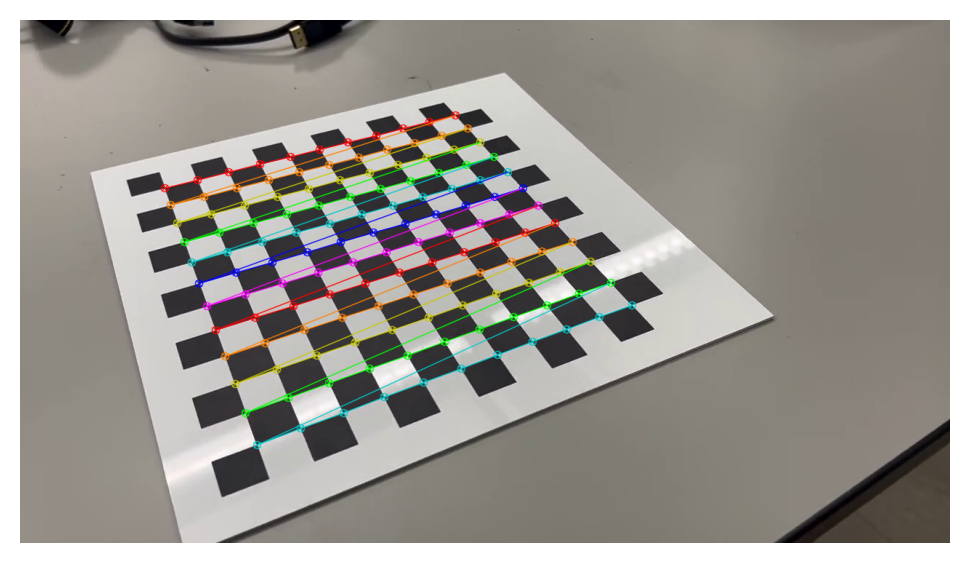

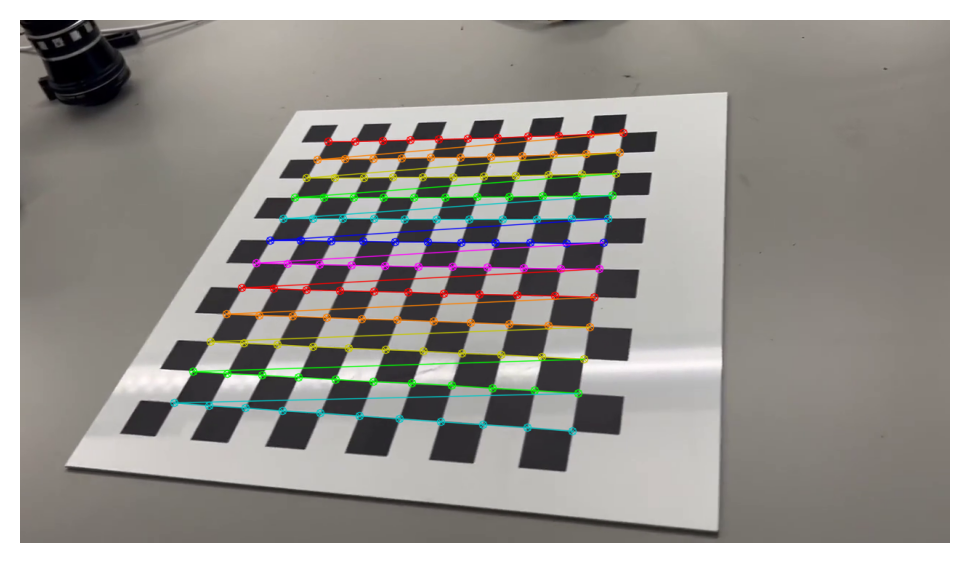

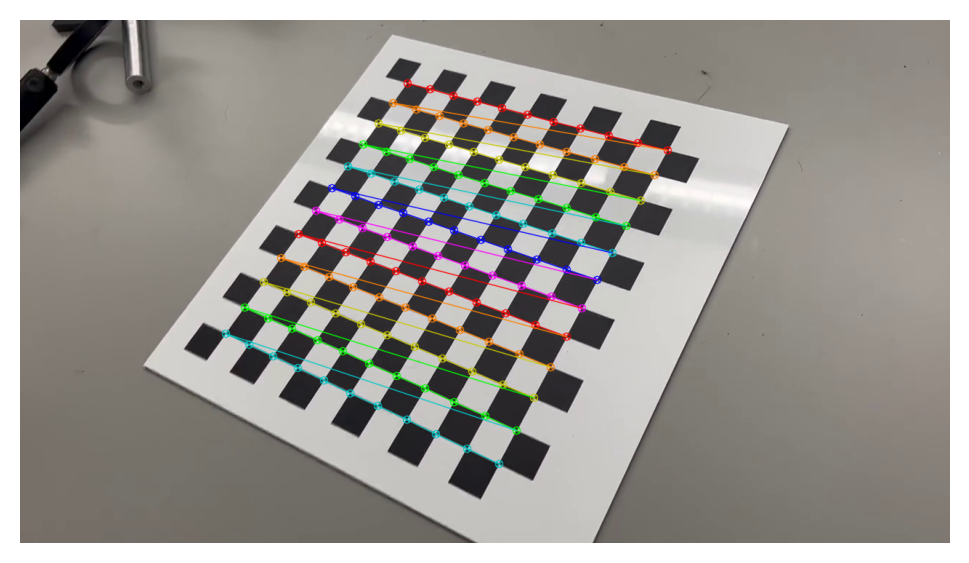

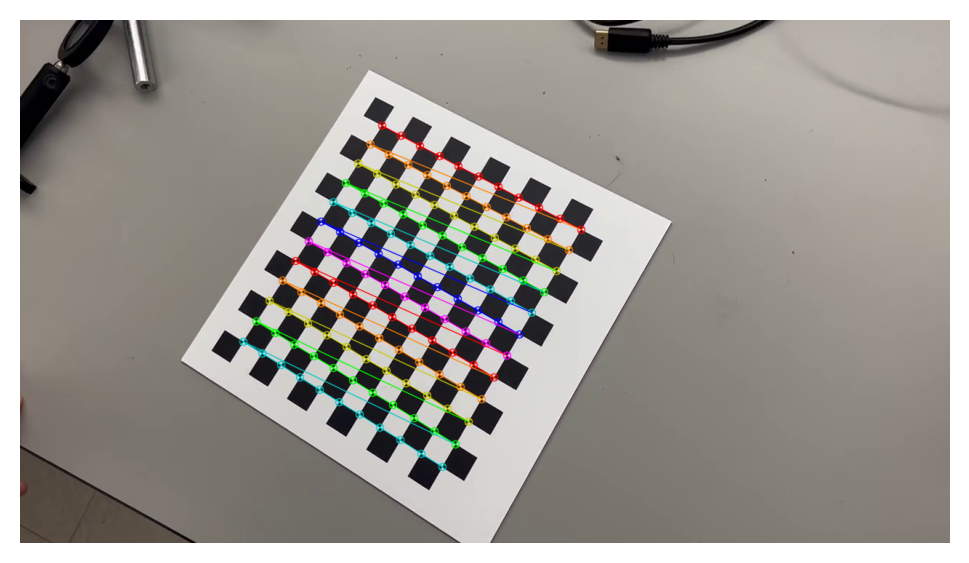

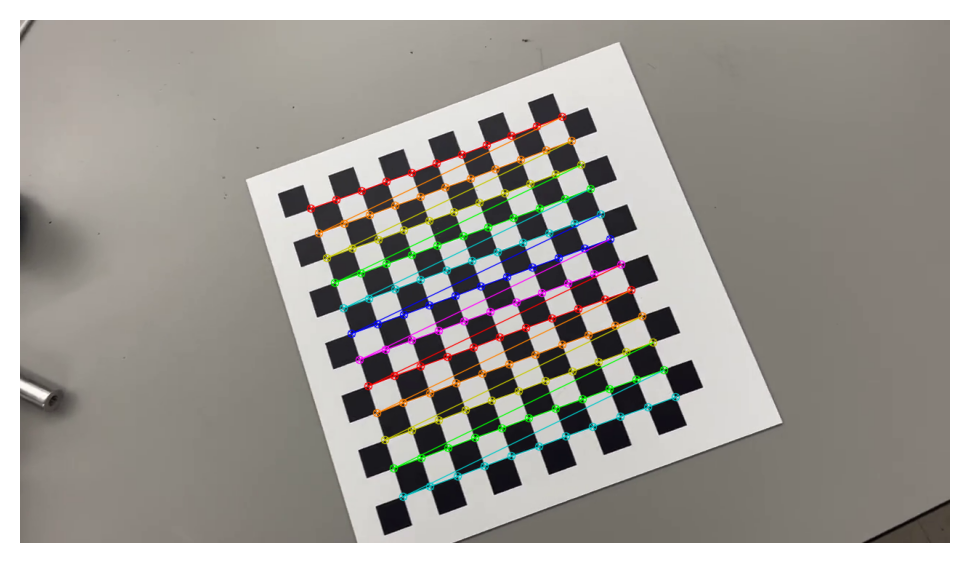

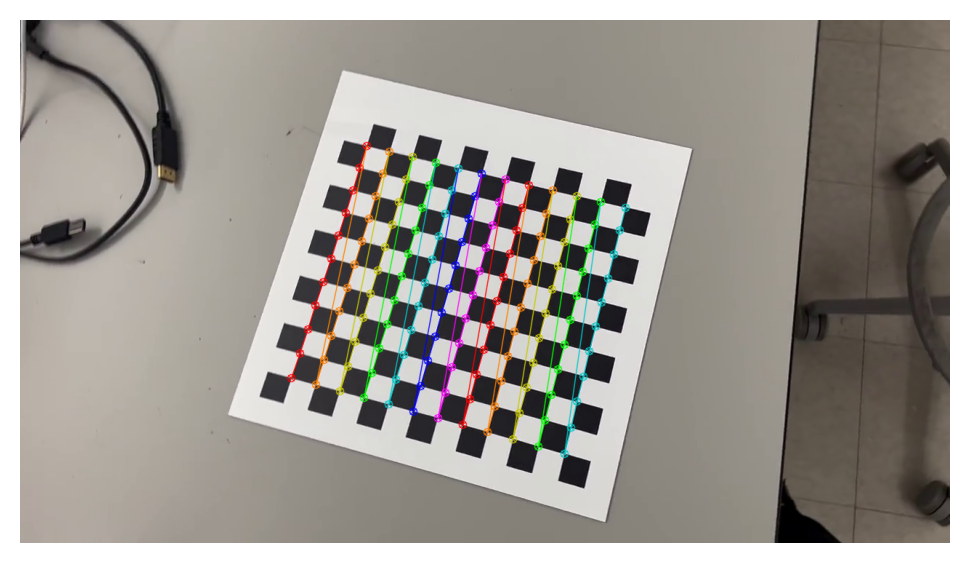

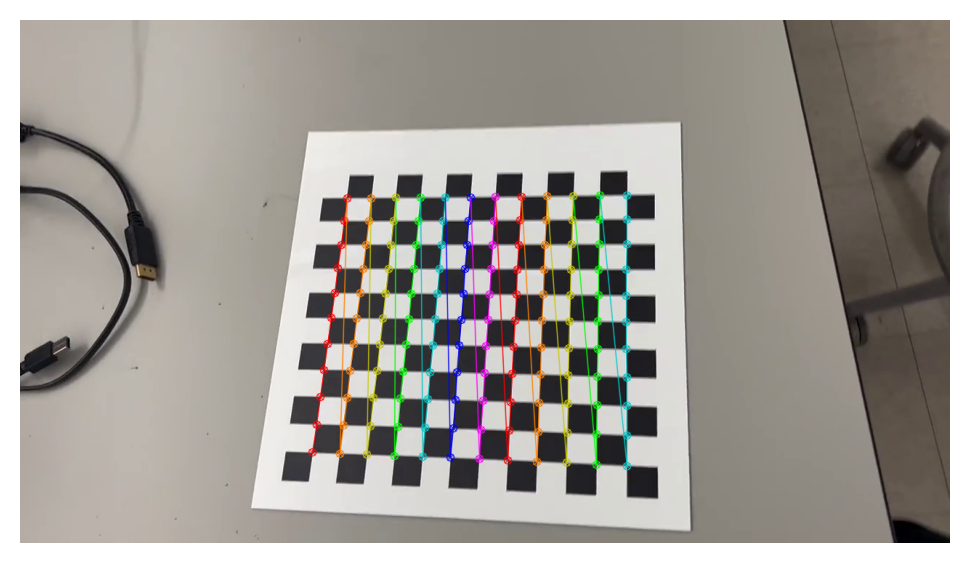

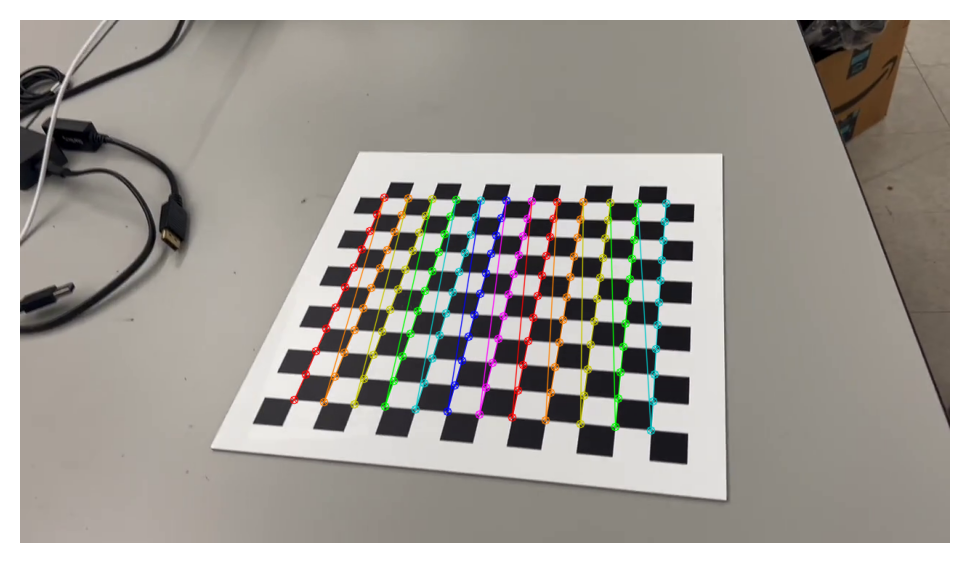

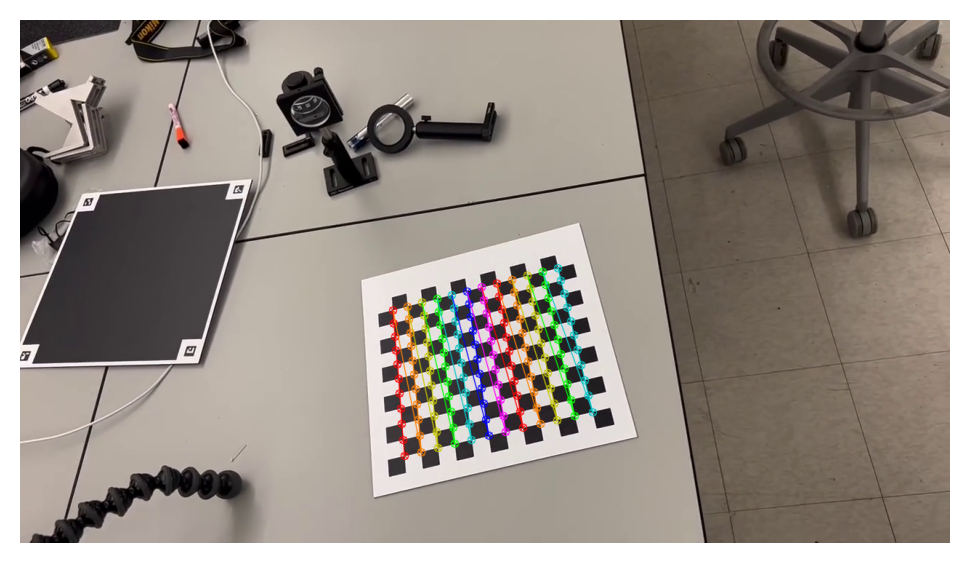

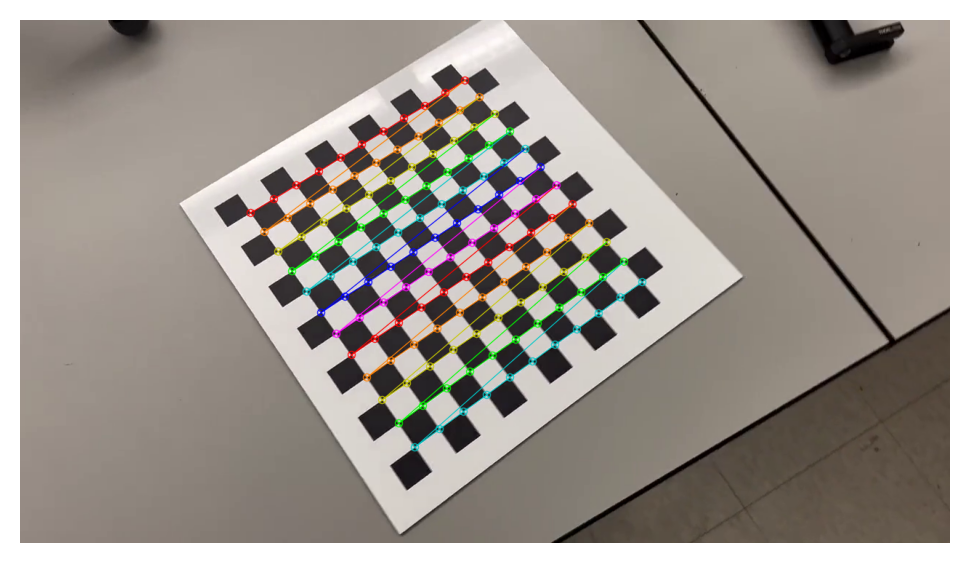

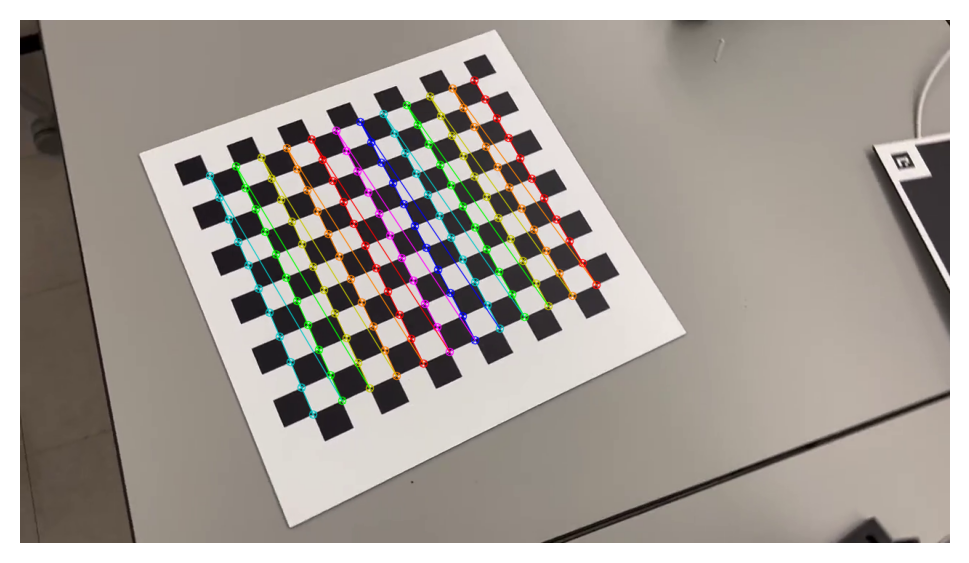

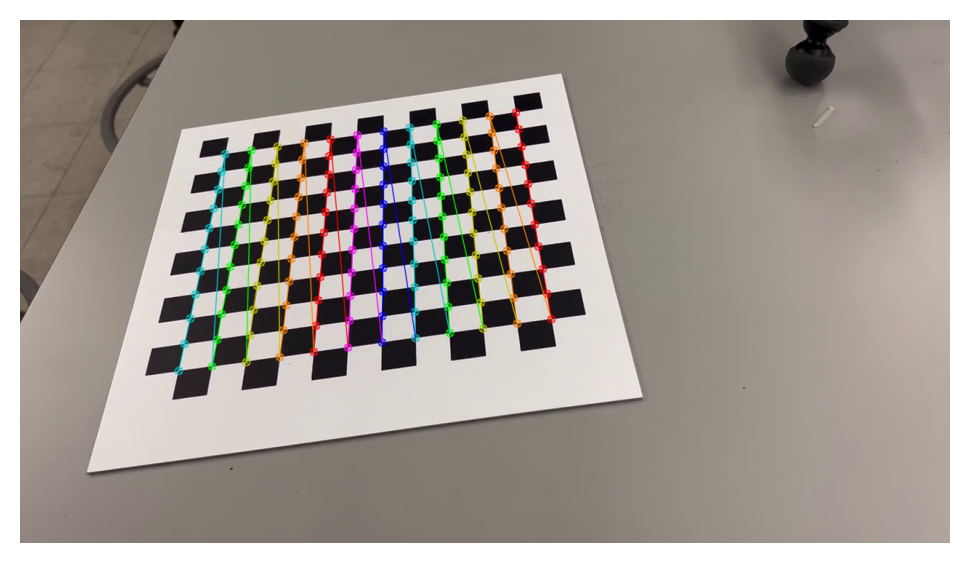

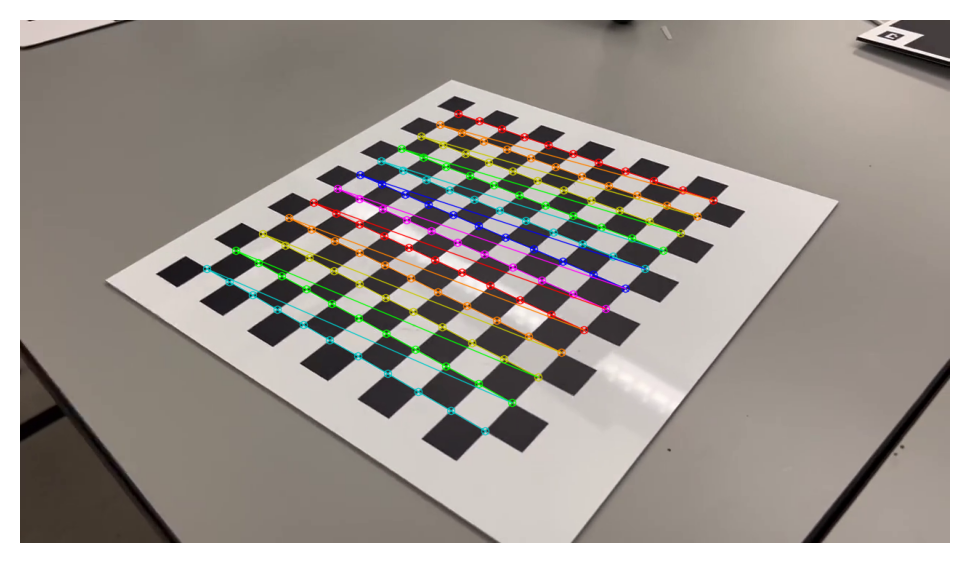

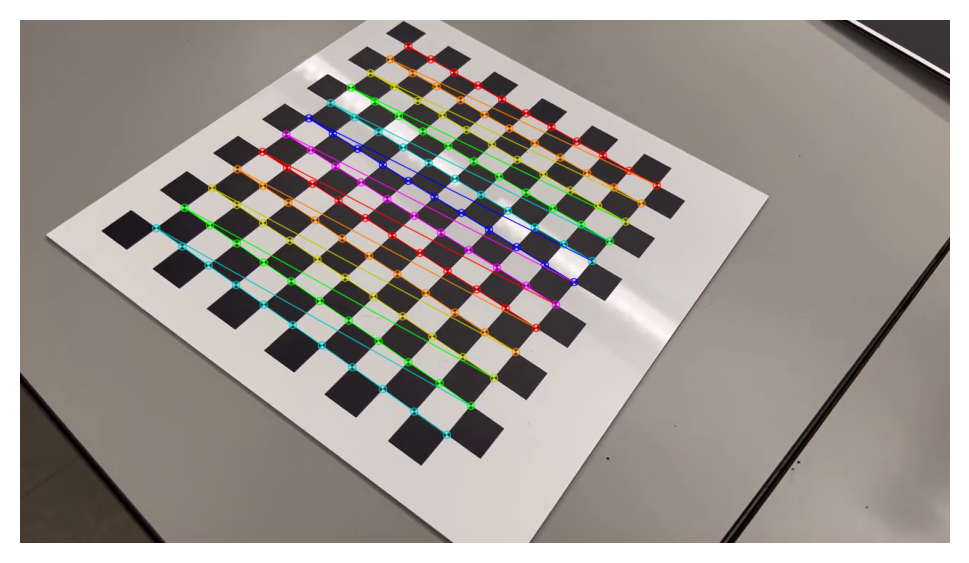

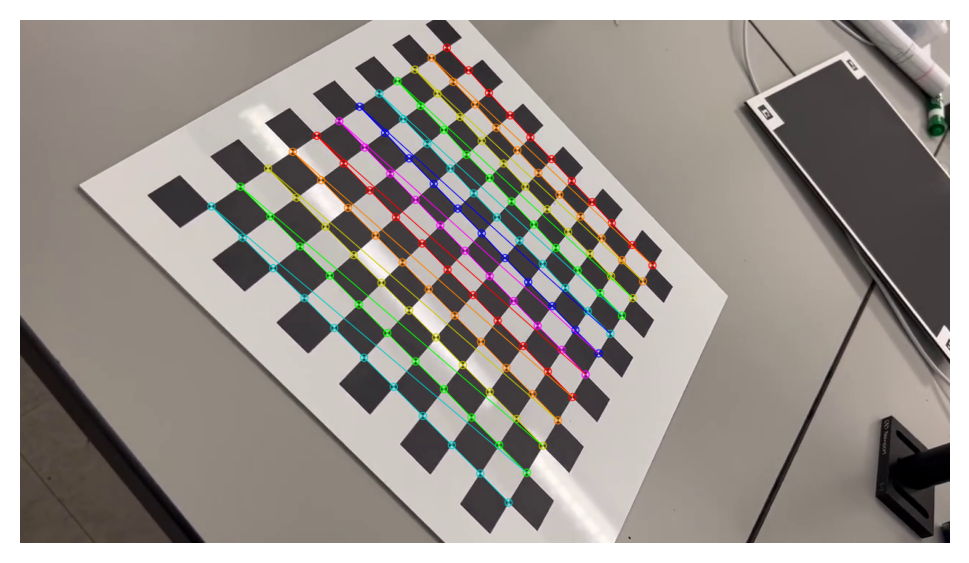

In [11]:
dirpath = 'calibrate_images/13_pro_video'
video_format = 'mp4'
square_size = 0.02
a = glob.glob(dirpath + '/' + '*.' + video_format)
ret, mtx, dist, rvecs, tvecs = calibrate(dirpath, video_format, square_size, width=11, height=12)
save_coefficients(mtx, dist, '13pro_coef')
print("Calibration is finished. RMS: ", ret)